In [26]:
# !pip install mlxtend

In [27]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, average_precision_score
from sklearn.preprocessing import LabelEncoder
from scipy.signal import hilbert
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import pickle
import os


from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

In [28]:
dtypes = {
"duration": np.int8,
"protocol_type": object,
"service": object,
"flag": object,
"src_bytes":  np.int8,
"dst_bytes":  np.int8,
"land": np.int8,
"wrong_fragment":  np.int8,
"urgent": np.int8,
"hot": np.int8,
"m_failed_logins":  np.int8,
"logged_in":  np.int8,
"num_compromised":  np.int8,
"root_shell":  np.int8,
"su_attempted":  np.int8,
"num_root": np.int8,
"num_file_creations":  np.int8,
"num_shells":  np.int8,
"num_access_files":  np.int8,
"num_outbound_cmds":  np.int8,
"is_host_login":  np.int8,
"is_guest_login":  np.int8,
"count": np.int8,
"srv_count":  np.int8,
"serror_rate": np.float16,
"srv_serror_rate": np.float16,
"rerror_rate": np.float16,
"srv_rerror_rate": np.float16,
"same_srv_rate": np.float16,
"diff_srv_rate": np.float16,
"srv_diff_host_rate": np.float16,
"dst_host_count":  np.int8,
"dst_host_srv_count":  np.int8,
"dst_host_same_srv_rate": np.float16,
"dst_host_diff_srv_rate": np.float16,
"dst_host_same_src_port_rate": np.float16,
"dst_host_srv_diff_host_rate": np.float16,
"dst_host_serror_rate": np.float16,
"dst_host_srv_serror_rate": np.float16,
"dst_host_rerror_rate": np.float16,
"dst_host_srv_rerror_rate": np.float16,
"label": object
}

columns = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land","wrong_fragment","urgent","hot","m_failed_logins",
"logged_in", "num_compromised","root_shell","su_attempted","num_root","num_file_creations","num_shells","num_access_files",
"num_outbound_cmds","is_host_login","is_guest_login","count","srv_count","serror_rate","srv_serror_rate","rerror_rate","srv_rerror_rate",
"same_srv_rate","diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate","dst_host_diff_srv_rate",
"dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
"dst_host_srv_rerror_rate","label"]

In [29]:
df = pd.read_csv("data/kdd99/kddcup.data_10_percent/kddcup.data_10_percent_corrected", sep=",", names=columns, dtype=dtypes, index_col=None)

In [30]:
df.label.value_counts()

label
smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: count, dtype: int64

In [31]:
def data_preprocessing_lstm(data):
    print("")
    print(".")
    print(data.info())
    print(data.describe())
    print("。")

    categorical_features = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
    data_encoded = pd.get_dummies(data, columns=categorical_features)


    numerical_features = data_encoded.select_dtypes(include=['float16', 'int8']).columns
    scaler = MinMaxScaler()
    data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])


    data_encoded = data_encoded.replace([np.inf, -np.inf], np.nan)
    data_encoded = data_encoded.dropna()

    data_encoded.label=data_encoded.label.apply(lambda x: 0 if x == 'normal.' else 1)

    train_samples =data_encoded.sample(100000)

    X = train_samples.drop(['label'], axis=1)

    y = train_samples['label']


    X = X.astype(np.float64)

    X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

#     scaler = MinMaxScaler()
#     X = scaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    print("")
    return X_train, X_test, y_train, y_test, train_samples

In [32]:
def data_preprocessing(data):
    # Drop any existing NaN values in the dataset
    data.dropna(inplace=True)
    
    categorical_features = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
    data_encoded = pd.get_dummies(data, columns=categorical_features)

    numerical_features = data_encoded.select_dtypes(include=['float16', 'int8']).columns
    print("Numerical Features:", numerical_features)
    scaler = StandardScaler()
    data_encoded[numerical_features] = scaler.fit_transform(data_encoded[numerical_features])

    X = data_encoded.drop('label', axis=1)
    y = data_encoded['label']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    return X_train, X_test, y_train, y_test, data

# def eemd_worker(data):
#     eemd = EEMD(trials=5, std=0.3)  # Assuming std is a constant value
#     imfs = eemd.eemd(data.reshape(-1), max_imf=3)
#     return imfs.tolist()

# def parallel_eemd(data):
#     n_processes = cpu_count()
#     with Pool(processes=n_processes) as pool:
#         results = []
#         for i in range(data.shape[0]):
#             result = pool.apply_async(eemd_worker, args=(data[i],))
#             results.append(result)
#         imfs = []
#         for result in tqdm(results, desc="EEMD Progress", unit="sample"):
#             imfs.append(result.get())
#     return imfs

# def signal_decomposition(X_train, X_test):
#     # Assuming imfs_train_file and imfs_test_file are defined somewhere
#     if os.path.exists(imfs_train_file) and os.path.exists(imfs_test_file):
#         with open(imfs_train_file, 'rb') as f:
#             imfs_train = pickle.load(f)
#         with open(imfs_test_file, 'rb') as f:
#             imfs_test = pickle.load(f)
#     else:
#         imfs_train = parallel_eemd(X_train)
#         imfs_test = parallel_eemd(X_test)
        
#         # Save IMFs to files
#         with open(imfs_train_file, 'wb') as f:
#             pickle.dump(imfs_train, f)
#         with open(imfs_test_file, 'wb') as f:
#             pickle.dump(imfs_test, f)

#     return imfs_train, imfs_test

# def hilbert_spectrum(imf):
#     analytical_signal = hilbert(imf)
#     amplitude_envelope = np.abs(analytical_signal)
#     instantaneous_phase = np.unwrap(np.angle(analytical_signal))
#     instantaneous_frequency = np.diff(instantaneous_phase) / (2.0 * np.pi)
#     return amplitude_envelope, np.concatenate(([0], instantaneous_frequency))

# def extract_features_for_one_sample(imfs):
#     features = []
#     for imf in imfs:
#         amp_env, inst_freq = hilbert_spectrum(imf)
#         imf_features = [
#             np.mean(imf), np.std(imf), np.max(imf), np.min(imf),
#             np.median(amp_env), np.std(amp_env),
#             np.median(inst_freq), np.std(inst_freq)
#         ]
#         features.extend(imf_features)
#     return features

# def extract_features(imfs_data):
#     features = [extract_features_for_one_sample(imf_sample) for imf_sample in imfs_data]
#     return np.array(features)

# def time_frequency_analysis(imfs_train, imfs_test):
#     X_train_features = extract_features(imfs_train)
#     X_test_features = extract_features(imfs_test)
#     return X_train_features, X_test_features

def train_decision_tree(X_train, y_train):
    param_grid = {'max_depth': [20], 'min_samples_split': [2]}
    clf = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)

    label_encoder = LabelEncoder()
    y_train_encoded = label_encoder.fit_transform(y_train)
    
    clf.fit(X_train, y_train_encoded)
    return clf, label_encoder

def evaluate_performance(y_true, y_pred):
    
#     accuracy = accuracy_score(y_true, y_pred)
#     precision = precision_score(y_true, y_pred, average='weighted')
#     recall = recall_score(y_true, y_pred, average='weighted')
#     f1 = f1_score(y_true, y_pred, average='weighted')
    
    prob=[-0.2,-0.1,-0.05,0,0.005,0.1, 0.2,0.3,0.4]
    for p in prob:
        pred_value =[1 if i<p   else 0 for i in y_pred]
        f1=f1_score(y_true,pred_value)
        acc=accuracy_score(y_true,pred_value)
        precision=average_precision_score(y_true,pred_value)
        recall= recall_score(y_true,pred_value)
        print(f'prob ={p} and f1 score ={f1} : accuracy={acc} : precision={precision} : recall={recall}')
        print(pred_value.count(0),pred_value.count(1))
    return acc, precision, recall, f1, pred_value

def anomaly_detection(X_train_features, y_train, X_test_features, y_test):
    clf, label_encoder = train_decision_tree(X_train_features, y_train)
    y_pred_encoded = clf.predict(X_test_features)
    y_pred = label_encoder.inverse_transform(y_pred_encoded)
    return y_pred

def print_anomalies(data, y_test, y_pred):
    test_indices = data.index[data.index.isin(y_test.index)]
    anomaly_data = data.loc[test_indices[y_pred != 'normal.']]
    # for _, row in anomaly_data.iterrows():
    #     # print(row.values)


In [33]:

data = pd.read_csv("data/kdd99/kddcup.data_10_percent/kddcup.data_10_percent_corrected", sep=",", names=columns, dtype=dtypes, index_col=None)

X_train, X_test, y_train, y_test, original_data = data_preprocessing_lstm(data)

df_train= original_data[original_data.label==0]

X_train_new = df_train.drop(['label'], axis=1)

X_train_new = X_train_new.astype(np.float64)

X_train_new = np.nan_to_num(X_train_new, nan=0.0, posinf=0.0, neginf=0.0)

# scaler = MinMaxScaler()
# X_train_new = scaler.fit_transform(X_train_new)




.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int8   
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int8   
 5   dst_bytes                    494021 non-null  int8   
 6   land                         494021 non-null  int8   
 7   wrong_fragment               494021 non-null  int8   
 8   urgent                       494021 non-null  int8   
 9   hot                          494021 non-null  int8   
 10  m_failed_logins              494021 non-null  int8   
 11  logged_in                    494021 non-null  int8   
 12  num_compromised              494021 non-null  int8   
 

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape, original_data.shape, df_train.shape

((80000, 121), (20000, 121), (80000,), (20000,), (100000, 122), (19662, 122))

In [35]:
X_test[1:20, :].shape

(19, 121)

In [36]:
# data = pd.read_csv("data/kdd99/kddcup.data_10_percent/kddcup.data_10_percent_corrected", sep=",", names=columns, dtype=dtypes, index_col=None)
# X_train, X_test, y_train, y_test, original_data = data_preprocessing_lstm(data)

# def main():
# if __name__ == "__main__":
#     main()


In [37]:
input_shape = (X_train_new.shape[1], 1)

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(RepeatVector(1))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, activation='relu', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\zakar\anaconda3\envs\DeepLearning6150\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [38]:
# ##LSTM 2nd Structure
# input_shape = (X_train_new.shape[1], 1)

# model = Sequential()
# model.add(LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(32, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(16, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(8, activation='relu', return_sequences=False))
# model.add(Dropout(0.1))
# model.add(RepeatVector(1))
# model.add(LSTM(8, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(16, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(32, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(64, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))
# model.add(LSTM(128, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(1)))

# model.compile(optimizer='adam', loss='mean_squared_error')

In [39]:
# Train the model
history = model.fit(X_train_new, X_train_new, epochs=10, batch_size=64, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# Plot training history if needed

X_test_slice = X_test[0:2000, :]
y_test_slice = y_test[0:2000]

# Make predictions on the test set
y_pred = model.predict(X_test_slice)
# arr = np.squeeze(predictions)


accuracy, precision, recall, f1, pred_value = evaluate_performance (y_test_slice, y_pred)

Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 48s 144ms/step - loss: 0.0846 - val_loss: 0.0821
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 39s 141ms/step - loss: 0.0823 - val_loss: 0.0821
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 39s 142ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 40s 145ms/step - loss: 0.0822 - val_loss: 0.0821
Epoch 6/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 40s 146ms/step - loss: 0.0822 - val_loss: 0.0821
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step
prob =-0.2 and f1 score =0.0 : accuracy=0.195 : precision=0.805 : recall=0.0
2000 0
prob =-0.1 and f1 score =0.0 : accuracy=0.195 : precision=0.805 : recall=0.0
2000 0
prob =-0.05 and f1 score =0.0 : accuracy=0.195 : precision=0.805 : recall=0.0
2000 0
prob =0 and f1 score =0.0 : accuracy=0.195 : precision=0.805 : recall=0.0
2000 0
prob =0.005 and f1 score =0.0 : accuracy=0.195 : precision=0.805 : recall=0.0
2000 0
prob =0

In [40]:
y_test[0:200]

226267    1
382353    1
203481    1
34610     0
478479    1
         ..
262098    1
312678    1
48348     1
32507     0
130811    1
Name: label, Length: 200, dtype: int64

In [41]:

arr = np.squeeze(y_pred)

# Calculate reconstruction errors
mse = []

# Calculate reconstruction errors
for i in range(0, y_test_slice.shape[0]):
    mse.append(np.mean(np.power(y_test_slice.iloc[i] - arr[i], 2)))

# Convert mse to numpy array if needed
mse = np.array(mse)
threshold = np.mean(mse) + 2 * np.std(mse)

# Classify anomalies
anomalies = np.where(mse > 0.1, 1, 0)

# # Evaluate the model
accuracy_2 = np.mean(anomalies == y_test_slice)
print("Accuracy:", accuracy_2)



Accuracy: 1.0


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='predicted label', ylabel='true label'>)

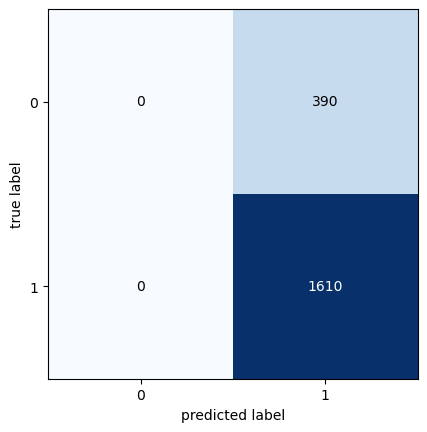

In [42]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test_slice,pred_value )
plot_confusion_matrix(conf_mat=mat)

In [43]:
# index_list=df_train.index
# df_train=df_train.drop(index_list)

# y_test = df_train['label']

    
# X_train, X_test, y_train, y_test, original_data = data_preprocessing_lstm(data)

# feature_data = pd.DataFrame(X_train)
# label_data   = pd.DataFrame(y_train)

# test_data = pd.concat([X_train, label_data], axis=1)

# df.label=df.label.apply(lambda x: 0 if x == 'normal.' else 1)    
# df_train=data[df.label==0].sample(5000)  

#      # imfs_train, imfs_test = signal_decomposition(X_train, X_test)
#      # X_train_features, X_test_features = time_frequency_analysis(imfs_train, imfs_test)
#      y_pred = anomaly_detection(X_train, y_train, X_test, y_test)

#      accuracy, precision, recall, f1 = evaluate_performance(y_test, y_pred)
#      # print_anomalies(original_data, y_test, y_pred)
#      # print(y_pred)
#      print(accuracy, precision, recall, f1)

#     # data.dropna(inplace=True)
    
#     # categorical_features = ['protocol_type', 'service', 'flag', 'land', 'logged_in', 'is_host_login', 'is_guest_login']
#     # data_encoded = pd.get_dummies(data, columns=categorical_features)




In [44]:
# # Define input shape
# input_shape = (X_train.shape[1] - 1, 1)

# def make_lstm_model():
# # Define the LSTM autoencoder model
#     model = Sequential()
#     model.add(LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(64, activation='relu', return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(32, activation='relu', return_sequences=False))
#     model.add(Dropout(0.2))
#     model.add(RepeatVector(1))
#     model.add(LSTM(32, activation='relu', return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(64, activation='relu', return_sequences=True))
#     model.add(Dropout(0.2))
#     model.add(LSTM(128, activation='relu', return_sequences=True))
#     model.add(TimeDistributed(Dense(1)))
#     return model

# model.compile(optimizer='adam', loss='mean_squared_error')

In [45]:

# # Train the model
# history = model.fit(X_train, X_train, epochs=10, batch_size=64, validation_split=0.1, callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)])

# # Plot training history if needed

# # Make predictions on the test set
# predictions = model.predict(X_test)
# arr = np.squeeze(predictions)

# # Calculate reconstruction errors
# mse = []

# # Calculate reconstruction errors
# for i in range(0, y_test.shape[0]):
#     mse.append(np.mean(np.power(y_test.iloc[i] - arr[i], 2)))

# # Convert mse to numpy array if needed
# mse = np.array(mse)
# threshold = np.mean(mse) + 2 * np.std(mse)

# # Classify anomalies
# anomalies = np.where(mse > threshold, 1, 0)

# # # Evaluate the model
# accuracy = np.mean(anomalies == y_test)
# print("Accuracy:", accuracy)



In [46]:
163/200

0.815

In [47]:
mse.shape

(2000,)